# SHT Check Gradients

Here we're checking that the gradients computed for the SHT coupling are valid.

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import jax
import jax.numpy as jnp
import nfjax.shtlc as lc
import autograd
import autograd.numpy as anp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## With NumPy & Autograd

Let's first try out the plain NumPy with autograd,

In [4]:
lmax, nlat, nlon, D = 31, 32, 64, 0.0004
_, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True, np=anp)
np.testing.assert_equal(0, L.imag)
L = L.real.astype('f')

but using our new grad compatible implementation of `f`,

In [12]:
def apply_L(L, x, np=np):
    X = np.fft.rfft(x, axis=1)
    X = np.hstack(
        (np.einsum('abc,ca->ba', L, X[:,:lmax]),
         np.zeros((X.shape[0], X.shape[1] - lmax), jnp.complex64)
        )
    )
    y = np.real(np.fft.irfft(X, axis=1))
    return y

have a test value,

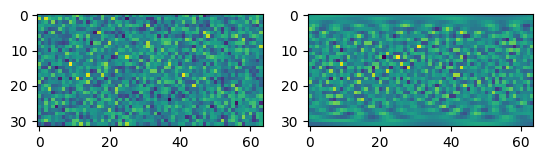

In [13]:
x0 = np.random.randn(nlat, nlon)
x1 = apply_L(L, x0)
subplot(121); imshow(x0); subplot(122); imshow(x1)

a loss function

In [14]:
def loss(x0h):
    x1h = apply_L(L, x0h, np=anp)
    sse = anp.sum(anp.square(x1 - x1h))
    return sse

x0h = np.random.randn(nlat, nlon)
loss(x0), loss(x0h)

(0.0, 2424.7795671679014)

and it's gradient

In [15]:
g_loss = autograd.grad(loss)

%timeit loss(x0h)
%timeit g_loss(x0h)

71.2 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
387 µs ± 4.84 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Here we see the overhead of autograd is fairly heavy.  Anyway, a simple optimization loop

In [18]:
x0h = np.random.randn(nlat, nlon)
for i in range(5):
    print(i, loss(x0h))
    x0h -= 0.1 * g_loss(x0h)

0 2308.188219324211
1 688.4211479701916
2 375.1683573666386
3 250.17372101642454
4 183.68622706876872


shows that our gradients here are correct. 

## With Jax

Let's try that with Jax,

In [34]:
L = jnp.array(L)
x1 = jnp.array(x1)

#@jax.jit
def loss(x0h):
    x1h = apply_L(L, x0h, np=jnp)
    sse = jnp.sum(jnp.square(x1 - x1h))
    return sse

x0h = jnp.array(np.random.randn(nlat, nlon).astype('f'))
print(loss(x0), loss(x0h))

g_loss = jax.grad(loss)

%timeit loss(x0h)
%timeit g_loss(x0h)

for i in range(5):
    print(i, loss(x0h))
    x0h -= 0.1 * g_loss(x0h)

3.051985e-11 2398.42
729 µs ± 6.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.76 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
0 2398.42
1 666.4641
2 354.6015
3 233.0774
4 169.769


This also works, and about 6x faster than `autograd.grad` with `jax.jit`.

## Inside a scan

With working gradients for `apply_L` let's try the filter from notebook [13](13%20SHT%20Matrix%20form%20parallelism.ipynb#Inside-a-scan),

In [42]:
ts = jnp.r_[:500]*0.1
k = 0.2

@jax.jit
def simulate(ts, x0, k):
    dt = ts[1] - ts[0]
    def f(x, t):
        lx = 3.14*x + apply_L(L, x, np=jnp)
        x = x + dt * (-x + k * lx)
        return x, x
    _, x_t = jax.lax.scan(f, x0, ts)
    return x_t

xt = simulate(ts, x0, k)

In [43]:
@jax.jit
def loss(x0h):
    xth = simulate(ts, x0h, k)
    sse = jnp.sum(jnp.square(xt - xth))
    return sse

loss(x0), loss(x0h)

(Array(0., dtype=float32), Array(44571.504, dtype=float32))

In [44]:
g = jax.jit(jax.grad(loss))
g(x0h)
%timeit simulate(ts, x0, k)
%timeit g(x0h)

12.5 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.8 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
x0h = jnp.array(np.random.randn(nlat, nlon).astype('f'))

for i in range(5):
    print(i, loss(x0h))
    x0h -= 0.01 * g(x0h)

0 606728.5
1 3587954400.0
2 32858192000000.0
3 3.6287412e+17
4 4.6620014e+21


ensmaller the step size:

In [47]:
x0h = jnp.array(np.random.randn(nlat, nlon).astype('f'))

for i in range(50):
    if i % 10 == 0:
        print(i, loss(x0h))
    x0h -= 0.0001 * g(x0h)

0 824430.7
10 76615.72
20 61376.21
30 53723.953
40 48314.34


Looks good. 